# Gradient Episodic Memory for Continual Learning

We adapt the GEM algorithm to train the ResNet18 model on the CIFAR-10 Dataset. The GEM algorithm is a continual learning algorithm that prevents catastrophic forgetting by constraining the gradient updates on the new task to be orthogonal to the gradients of the previous tasks. The algorithm is implemented in PyTorch.

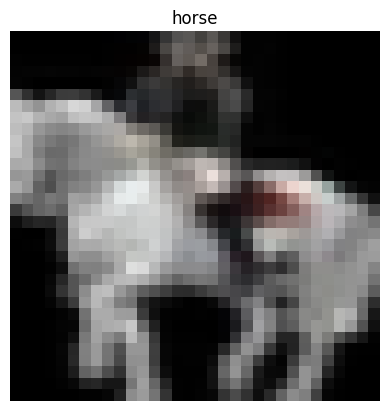

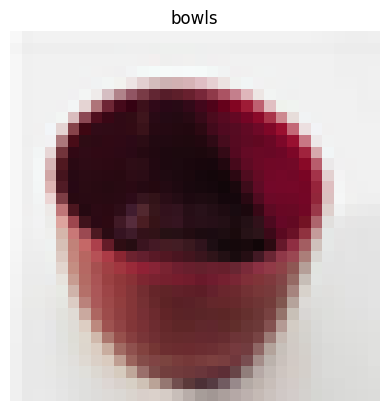

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import time
from cifar import load_cifar10_data, split_into_classes, get_class_indexes, load_data
import cifar
from torch.utils.data import DataLoader
import random
import os
import sys
sys.path.append(os.path.abspath("."))  # Adds the current directory
# from GEM.gem import *
from GEM.args import *
from torch.nn.functional import relu, avg_pool2d
import torch.nn as nn
import quadprog

AGEM = True
PRETRAIN = 0 # number of initial classes to pretrain on
# Globals 
DATASET = 'cifar-100'
DATASET_PATH = 'cifar-100-python' 
CLASSES = cifar.CLASSES
SHUFFLEDCLASSES = CLASSES.copy()
if DATASET == 'cifar-10':
    CLASSES = cifar.CLASSES
    SHUFFLEDCLASSES = CLASSES.copy()
elif DATASET == 'cifar-100':
    CLASSES = cifar.CLASSES_100_UNORDERED
    SHUFFLEDCLASSES = CLASSES.copy()




In [2]:
## Scraped code fundamental for GEM this is the code required to create a resnet18 model from scratch 
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes, nf):
        super(ResNet, self).__init__()
        self.in_planes = nf
        self.conv1 = conv3x3(3, nf * 1)
        self.bn1 = nn.BatchNorm2d(nf * 1)
        self.layer1 = self._make_layer(block, nf * 1, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, nf * 2, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, nf * 4, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, nf * 8, num_blocks[3], stride=2)
        self.linear = nn.Linear(nf * 8 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        bsz = x.size(0)
        out = relu(self.bn1(self.conv1(x.view(bsz, 3, 32, 32))))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(nclasses, nf=20):
    return ResNet(BasicBlock, [2, 2, 2, 2], nclasses, nf)




In [3]:
### Now lets make the GEM model --  we will scrape this from the GEM code
def compute_offsets(task, nc_per_task, is_cifar):
    """
        Compute offsets for cifar to determine which
        outputs to select for a given task.
    """
    val1 = max(PRETRAIN - nc_per_task, 0)
    val2 = max(PRETRAIN - nc_per_task, 0)
    if task == 0:
        val1 = 0
        val2 = max(PRETRAIN - nc_per_task, 0)
    offset1 = task * nc_per_task + val1
    offset2 = (task + 1) * nc_per_task + val2    
    return offset1, offset2


def store_grad(pp, grads, grad_dims, tid):
    """
        This stores parameter gradients of past tasks.
        pp: parameters
        grads: gradients
        grad_dims: list with number of parameters per layers
        tid: task id
    """
    # store the gradients
    grads[:, tid].fill_(0.0)
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            grads[beg: en, tid].copy_(param.grad.data.view(-1))
        cnt += 1


def overwrite_grad(pp, newgrad, grad_dims):
    """
        This is used to overwrite the gradients with a new gradient
        vector, whenever violations occur.
        pp: parameters
        newgrad: corrected gradient
        grad_dims: list storing number of parameters at each layer
    """
    cnt = 0
    for param in pp():
        if param.grad is not None:
            beg = 0 if cnt == 0 else sum(grad_dims[:cnt])
            en = sum(grad_dims[:cnt + 1])
            this_grad = newgrad[beg: en].contiguous().view(
                param.grad.data.size())
            param.grad.data.copy_(this_grad)
        cnt += 1


def project2cone2(gradient, memories, margin=0.5, eps=1e-3):
    """
        Solves the GEM dual QP described in the paper given a proposed
        gradient "gradient", and a memory of task gradients "memories".
        Overwrites "gradient" with the final projected update.

        input:  gradient, p-vector
        input:  memories, (t * p)-vector
        output: x, p-vector
    """
    memories_np = memories.cpu().t().double().numpy()
    gradient_np = gradient.cpu().contiguous().view(-1).double().numpy()
    t = memories_np.shape[0]
    P = np.dot(memories_np, memories_np.transpose())
    P = 0.5 * (P + P.transpose()) + np.eye(t) * eps
    q = np.dot(memories_np, gradient_np) * -1
    G = np.eye(t)
    h = np.zeros(t) + margin
    v = quadprog.solve_qp(P, q, G, h)[0]
    x = np.dot(v, memories_np) + gradient_np
    gradient.copy_(torch.Tensor(x).view(-1, 1))
    #penis
def agemprojection(gradient, gradient_memory, margin=0.5, eps=1e-5):
    """
    Projection of gradients for A-GEM with the memory approach
    Use averaged gradient memory for projection
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """

    g = gradient_memory.t().double().mean(axis=0).cuda() # * margin
    gref = gradient.contiguous().view(-1).double().cuda()
    g_transpose = g.view(1, -1)
    dot_prod = torch.dot(g_transpose.squeeze(), gref.squeeze())
    dot_prod = dot_prod / torch.dot(g_transpose.squeeze(), g.squeeze())
    
    # add epsilon to prevent 0 values from fucking everything up  
    epsvector = torch.Tensor([eps]).cuda()
    
    x = g + (gref * abs(dot_prod)) + epsvector
    gradient.copy_(torch.Tensor(x).view(-1, 1))
    
def replay(gradient, gradient_memory):
    """
    Adds the gradients of the current task to the memory 
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """
    g = gradient_memory.t().double().mean(axis=0).cuda()
    gref = gradient.contiguous().view(-1).double().cuda()
    # simply add the gradients
    g = g + gref
    gradient.copy_(torch.Tensor(g).view(-1, 1))
    
def naiveretraining(gradient):
    """
    Naive retraining of the model on the current task
    
    input:  gradient, g-reference
    output: gradient, g-projected
    """
    g = gradient.t().double().mean(axis=0).cuda()
    gradient.copy_(torch.Tensor(g).view(-1, 1))

class Net(nn.Module):
    def __init__(self,
                 n_inputs,
                 n_outputs,
                 n_tasks,
                 args):
        super(Net, self).__init__()
        nl, nh = args.n_layers, args.n_hiddens
        self.margin = args.memory_strength
        self.net = ResNet18(n_outputs)
     

        self.ce = nn.CrossEntropyLoss()
        self.n_outputs = n_outputs

        self.opt = torch.optim.SGD(self.parameters(), args.lr)

        self.n_memories = args.n_memories
        self.gpu = args.cuda


        """
        Allocate episodic memory
        n_tasks: number of tasks
        n_memories: number of memories per task
        n_inputs: number of input features
        """

        # allocate episodic memory
        self.memory_data = torch.FloatTensor(
            n_tasks, self.n_memories, n_inputs)
        self.memory_labs = torch.LongTensor(n_tasks, self.n_memories)
        if args.cuda:
            self.memory_data = self.memory_data.cuda()
            self.memory_labs = self.memory_labs.cuda()

        # allocate temporary synaptic memory
        """ This is the memory that stores the gradients of the parameters of the network
            FOR each task. This is used to check for violations of the GEM constraint
            Assume:

            The model has 3 parameters with sizes 100, 200, and 300 elements respectively.
            n_tasks = 5 (number of tasks).
            The allocated tensors would have the following shapes:

            self.grad_dims: [100, 200, 300]
            self.grads: Shape [600, 5] (600 is the sum of 100, 200, and 300).
        """
        self.grad_dims = []
        for param in self.parameters():
            self.grad_dims.append(param.data.numel())
        self.grads = torch.Tensor(sum(self.grad_dims), n_tasks)
        if args.cuda:
            self.grads = self.grads.cuda()

        # allocate counters
        self.observed_tasks = []
        self.old_task = -1
        self.mem_cnt = 0
        minus = 0
        if PRETRAIN > 0:
            minus = 1
        else: 
            minus = 0
        self.nc_per_task = int((n_outputs - PRETRAIN) / (n_tasks - minus))

    def forward(self, x, t):
        output = self.net(x)
        if t == -1:
            return output
        # make sure we predict classes within the current task
        val1 = 0
        val2 = 0
        if t != 0:
            val1 = max(PRETRAIN - self.nc_per_task, 0)
            val2 = val1
        else:
            val1 = 0
            val2 = max(PRETRAIN - self.nc_per_task, 0)                                                 
        offset1 = int(t * self.nc_per_task + val1) #t = 0 0, 5 -----t = 1 5 , 6 ## t = 0 0 ,5 --- t =1 5, 7
        offset2 = int((t + 1) * self.nc_per_task + val2) 
        if offset1 > 0:
            output[:, :offset1].data.fill_(-10e10)
        if offset2 < self.n_outputs:
            output[:, offset2:self.n_outputs].data.fill_(-10e10)
        return output

    def observe(self, algorithm, x, t, y):
        # update memory
        if t != self.old_task:
            self.observed_tasks.append(t)
            self.old_task = t
            
        val = 0
        if t == 0:
            val = max(PRETRAIN,1)
        else:
            val = 1
        # Update ring buffer storing examples from current task
        bsz = y.data.size(0)
        if (algorithm == 'NAIVE'):
            self.zero_grad()
            loss = self.ce(self.forward(x, t), y)
            loss.backward()
            self.opt.step()
            return
        endcnt = min(self.mem_cnt + bsz, self.n_memories) #256
        effbsz = endcnt - self.mem_cnt # 256
        self.memory_data[t, self.mem_cnt: endcnt].copy_(
            x.data[: effbsz])
        if bsz == 1:
            self.memory_labs[t, self.mem_cnt] = y.data[0]
        else:
            self.memory_labs[t, self.mem_cnt: endcnt].copy_(
                y.data[: effbsz])
        self.mem_cnt += effbsz
        if self.mem_cnt == self.n_memories:
            self.mem_cnt = 0

        # compute gradient on previous tasks
        # if PRETRAIN == 0:
        #     val = 1
        # else:
        #     val = 0
        if len(self.observed_tasks) > 1: ### CHANGED FROM 1 to 0 SINCE WE PRETRAIN ON FST 5 CLASSES 
            for tt in range(len(self.observed_tasks) -1): ### CHANGED FROM -1 to -0 SINCE WE PRETRAIN ON FST 5 CLASSES 
                self.zero_grad()
                # fwd/bwd on the examples in the memory
                past_task = self.observed_tasks[tt]
                
                offset1, offset2 = compute_offsets(past_task, self.nc_per_task,
                                                   self.is_cifar)
                ptloss = self.ce(
                    self.forward(
                        self.memory_data[past_task],
                        past_task)[:, offset1: offset2],
                    self.memory_labs[past_task] - offset1)
                ptloss.backward()
                store_grad(self.parameters, self.grads, self.grad_dims,
                           past_task)

        # now compute the grad on the current minibatch
        self.zero_grad()

        offset1, offset2 = compute_offsets(t, self.nc_per_task, self.is_cifar) 
        loss = self.ce(self.forward(x, t)[:, offset1: offset2], y - offset1)
        loss.backward()

        # check if gradient violates constraints
        if len(self.observed_tasks) > 1: ### CHANGED FROM 1 to 0 SINCE WE PRETRAIN ON FST 5 CLASSES 
            if algorithm == 'AGEM':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                                self.grads.index_select(1, indx))
                if (dotp < 0).sum() != 0:
                    agemprojection(self.grads[:, t].unsqueeze(1), self.grads.index_select(1, indx), self.margin)
                    # copy gradients back
                    overwrite_grad(self.parameters, self.grads[:, t],
                                self.grad_dims)
            # copy gradient
            elif algorithm == 'GEM':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                dotp = torch.mm(self.grads[:, t].unsqueeze(0),
                                self.grads.index_select(1, indx))
                if (dotp < 0).sum() != 0:
                    project2cone2(self.grads[:, t].unsqueeze(1),
                                self.grads.index_select(1, indx), self.margin)
                    # copy gradients back
                    overwrite_grad(self.parameters, self.grads[:, t],
                                self.grad_dims)
            elif algorithm == 'REPLAY':
                store_grad(self.parameters, self.grads, self.grad_dims, t)
                indx = torch.cuda.LongTensor(self.observed_tasks[:-1]) if self.gpu \
                    else torch.LongTensor(self.observed_tasks[:-1])
                replay(self.grads[:, t].unsqueeze(1), self.grads.index_select(1, indx))
                # copy gradients back
                overwrite_grad(self.parameters, self.grads[:, t],
                            self.grad_dims)
        self.opt.step()


In [4]:
# define main function to run on the cifar dataset
N_TASKS = 20 #[2 tasks [airplane, automobile, etc], [dog , frog, etc]]
SIZE_OF_TASKS = 5
N_OUTPUTS = 100
N_INPUTS = 32 * 32 * 3
def run_cifar(algorithm, args, n_inputs=N_INPUTS, n_outputs=N_OUTPUTS, n_tasks=N_TASKS, size_of_task=SIZE_OF_TASKS, newclasses = SHUFFLEDCLASSES):
    # Set up the model
    model = Net(n_inputs, n_outputs, n_tasks, args)
    if args.cuda:
        model.cuda()
    model.is_cifar = True
    test_bs = 2500
    
    test_accuracies = []

    # Load data
    train_data, train_labels, test_data, test_labels = load_data(DATASET_PATH, DATASET)
    ## NEWCLASSES = suffled CLASSES
    NEWCLASSES = newclasses
    print("new ordering of classes: ", NEWCLASSES)
    oldClasstoNewClass = {}
    for i in range(len(CLASSES)):
        oldClasstoNewClass[i] = NEWCLASSES.index(CLASSES[i])
    for i in range(len(train_labels)):
        train_labels[i] = oldClasstoNewClass[train_labels[i]]
    for i in range(len(test_labels)):
        test_labels[i] = oldClasstoNewClass[test_labels[i]]

    pretrain_classses = NEWCLASSES[:PRETRAIN]
    pretrain_data, pretrain_labels = split_into_classes(train_data, train_labels, pretrain_classses, NEWCLASSES)
    pretest_data, pretest_labels = split_into_classes(test_data, test_labels, pretrain_classses, NEWCLASSES)
    tasks = []
    tests = []
    if PRETRAIN > 0:
        tasks = [[pretrain_data, pretrain_labels]]
        tests = [pretest_data, pretest_labels]
    else:

        tasks = []
        tests = []
    for i in range(n_tasks):
        if i == 0 and PRETRAIN > 0: ## as task 1 we already grab from 
            continue
        elif PRETRAIN > 0:
            task_data, task_labels = split_into_classes(train_data, train_labels, NEWCLASSES[PRETRAIN + size_of_task * (i-1) : PRETRAIN + size_of_task * (i)], NEWCLASSES)
            tasks.append([task_data, task_labels])
            partition_test_data, partition_test_labels = split_into_classes(test_data, test_labels, NEWCLASSES[PRETRAIN + size_of_task * (i-1) : PRETRAIN + size_of_task * (i)], NEWCLASSES)
            tests.append(partition_test_data)
            tests.append(partition_test_labels)
        else:
            task_data, task_labels = split_into_classes(train_data, train_labels, NEWCLASSES[size_of_task * i : size_of_task * (i + 1)] , NEWCLASSES)
            tasks.append([task_data, task_labels])
            partition_test_data, partition_test_labels = split_into_classes(test_data, test_labels, NEWCLASSES[size_of_task * i : size_of_task * (i + 1)] , NEWCLASSES)
            tests.append(partition_test_data)
            tests.append(partition_test_labels)
        
    # task1data, task1labels = split_into_classes(train_data, train_labels, ['airplane', 'automobile', 'bird', 'cat', 'deer']) ## pre train on this 
    # task2data, task2labels = split_into_classes(train_data, train_labels, ['dog', 'frog', 'horse', 'ship', 'truck']) ## split this guy up into 5 tasks 
    # # tasks = [[task1data, task1labels], [task2data,task2labels]]
    # test_data_per_class_1, test_labels_per_class_1 = split_into_classes(test_data, test_labels, ['airplane', 'automobile', 'bird', 'cat', 'deer'])
    # test_data_per_class_2, test_labels_per_class_2 = split_into_classes(test_data, test_labels, ['dog', 'frog', 'horse', 'ship', 'truck'])

    # Train the model
    for task in range(n_tasks):
        print("Training task: ", task  + 1)
        
        x = torch.Tensor(tasks[task][0].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(tasks[task][1]).long()
        
        if args.cuda:
            x, y = x.cuda(), y.cuda()
    
        for epoch in range(args.n_epochs):
            for j in range(0, len(tasks[task][0]), args.batch_size):
                current_data = x[j: j + args.batch_size]
                current_labels = y[j: j + args.batch_size]
                model.train()
                model.observe(algorithm, current_data, task, current_labels)
            #print("Epoch: ", epoch)
            
            #test the model after each epoch
            correct = 0
            total = len(tasks[task][0])
            for j in range(0,len(tasks[task][0]), test_bs):
                current_data = x[j: j + test_bs]
                current_labels = y[j: j + test_bs]
                output = model.forward(current_data, task)
                pred = output.data.max(1)[1]
                correct += (pred == current_labels).sum().item()
            #print("Accuracy: ", correct / total)
            # if correct / total > 0.85:
            #     break
            #   output loss only


    # Test the model after training
        for i in range(0, len(tests), 2):
            correct = 0
            total = len(tests[i])     

            # Test the model
            #print("Testing task: " , i // 2 + 1)
            
            x = torch.Tensor(tests[i].reshape(-1, 32*32*3)).float()
            y = torch.Tensor(tests[i+1]).long()
            if args.cuda:
                x, y = x.cuda(), y.cuda()
            for j in range(0,len(tests[i]), test_bs):
                current_data = x[j: j + test_bs]
                current_labels = y[j: j + test_bs]
                output = model.forward(current_data, i // 2)
                pred = output.data.max(1)[1]
                correct += (pred == current_labels).sum().item()
            #print("Accuracy: ", correct / total)
            test_accuracies.append(correct / total)
            
       
    return model, test_accuracies

        
# model, test_accuracies = run_cifar(Args())

In [5]:
def train_next_task(args, model, tasknum, n_inputs=N_INPUTS, n_outputs=N_OUTPUTS, n_tasks=N_TASKS, size_of_task=SIZE_OF_TASKS, newclasses = SHUFFLEDCLASSES):
    
    test_accuracies = []
    test_bs = 2500
    # Load data
    train_data, train_labels, test_data, test_labels = load_data(DATASET_PATH)
    ## NEWCLASSES = suffled CLASSES
    NEWCLASSES = newclasses
    print("new ordering of classes: ", NEWCLASSES)
    oldClasstoNewClass = {}
    for i in range(len(CLASSES)):
        oldClasstoNewClass[i] = NEWCLASSES.index(CLASSES[i])
    for i in range(len(train_labels)):
        train_labels[i] = oldClasstoNewClass[train_labels[i]]
    for i in range(len(test_labels)):
        test_labels[i] = oldClasstoNewClass[test_labels[i]]

    pretrain_classses = NEWCLASSES[:PRETRAIN]
    pretrain_data, pretrain_labels = split_into_classes(train_data, train_labels, pretrain_classses, NEWCLASSES)
    pretest_data, pretest_labels = split_into_classes(test_data, test_labels, pretrain_classses, NEWCLASSES)
    tasks = []
    tests = []
    if PRETRAIN > 0:
        tasks = [[pretrain_data, pretrain_labels]]
        tests = [pretest_data, pretest_labels]
    else:

        tasks = []
        tests = []
    for i in range(n_tasks):
        if i == 0 and PRETRAIN > 0: ## as task 1 we already grab from 
            continue
        elif PRETRAIN > 0:
            task_data, task_labels = split_into_classes(train_data, train_labels, NEWCLASSES[PRETRAIN + size_of_task * (i-1) : PRETRAIN + size_of_task * (i)], NEWCLASSES)
            tasks.append([task_data, task_labels])
            partition_test_data, partition_test_labels = split_into_classes(test_data, test_labels, NEWCLASSES[PRETRAIN + size_of_task * (i-1) : PRETRAIN + size_of_task * (i)], NEWCLASSES)
            tests.append(partition_test_data)
            tests.append(partition_test_labels)
        else:
            task_data, task_labels = split_into_classes(train_data, train_labels, NEWCLASSES[size_of_task * i : size_of_task * (i + 1)] , NEWCLASSES)
            tasks.append([task_data, task_labels])
            partition_test_data, partition_test_labels = split_into_classes(test_data, test_labels, NEWCLASSES[size_of_task * i : size_of_task * (i + 1)] , NEWCLASSES)
            tests.append(partition_test_data)
            tests.append(partition_test_labels)
        

    # Train the model
    task = tasknum - 1
    print("Training task: ", task  + 1)
    
    x = torch.Tensor(tasks[task][0].reshape(-1, 32*32*3)).float()
    y = torch.Tensor(tasks[task][1]).long()
    
    if args.cuda:
        x, y = x.cuda(), y.cuda()

    for epoch in range(args.n_epochs):
        for j in range(0, len(tasks[task][0]), args.batch_size):
            current_data = x[j: j + args.batch_size]
            current_labels = y[j: j + args.batch_size]
            model.train()
            model.observe(current_data, task, current_labels)
        #print("Epoch: ", epoch)
        
        #test the model after each epoch
        correct = 0
        total = len(tasks[task][0])
        for j in range(0,len(tasks[task][0]), test_bs):
            current_data = x[j: j + test_bs]
            current_labels = y[j: j + test_bs]
            output = model.forward(current_data, task)
            pred = output.data.max(1)[1]
            correct += (pred == current_labels).sum().item()
        #print("Accuracy: ", correct / total)
        if correct / total > 0.65:
            break
        #   output loss only


# Test the model after training
    for i in range(0, len(tests), 2):
        correct = 0
        total = len(tests[i])     

        # Test the model
        #print("Testing task: " , i // 2 + 1)
        
        x = torch.Tensor(tests[i].reshape(-1, 32*32*3)).float()
        y = torch.Tensor(tests[i+1]).long()
        if args.cuda:
            x, y = x.cuda(), y.cuda()
        for j in range(0,len(tests[i]), test_bs):
            current_data = x[j: j + test_bs]
            current_labels = y[j: j + test_bs]
            output = model.forward(current_data, i // 2)
            pred = output.data.max(1)[1]
            correct += (pred == current_labels).sum().item()
        #print("Accuracy: ", correct / total)
        test_accuracies.append(correct / total)
            
        
    return model, test_accuracies


In [6]:

def plot_task_accuracies(test_accuracies, num_tasks):
    for t in range(num_tasks):
        # Calculate the indices for the current set of accuracies
        start_idx = t * num_tasks
        end_idx = start_idx + num_tasks
        # Extract accuracies for all tasks after training task t+1
        print (test_accuracies)
        accuracies = test_accuracies[start_idx:end_idx]
        # Create labels for the tasks
        task_labels = [f'{i+1}' for i in range(num_tasks)]
        # Plot the accuracies
        plt.bar(task_labels, [acc * 100 for acc in accuracies])

        # Calculate the y-value for the horizontal line
        y_value = 100 / SIZE_OF_TASKS  # or use SIZE_OF_TASKS if it's defined separately

        # Add horizontal line across the bar chart
        plt.axhline(y=y_value, color='red', linestyle='--', label=f'y = {y_value:.2f}')
        
        plt.title(f'Test Set Accuracy for All Tasks (Post Task {t+1} Training)')
        plt.ylabel('Accuracy (%)')
        plt.xlabel('Task')
        plt.legend()
        plt.show()

def plot_comparison_accuracies(accuracies_list, num_tasks, num_models, model_names):
    bar_width = 0.2
    index = np.arange(num_tasks)
    
    for i, accuracies in enumerate(accuracies_list):
        start_idx = (num_tasks-1) * num_tasks
        end_idx = start_idx + num_tasks
        plt.bar(index + i * bar_width, [acc * 100 for acc in accuracies[start_idx:end_idx]], bar_width, label=model_names[i])
    
    plt.xlabel('Tasks')
    plt.ylabel('Accuracy (%)')
    plt.title('Comparison of Test Set Accuracies for All Models')
    plt.xticks(index + bar_width * (num_models - 1) / 2, [f'{i+1}' for i in range(num_tasks)])
    plt.legend()
    plt.savefig('comparison_accuracies.png')
    plt.show()
    

# Example usage:
# plot_comparison_accuracies([average_AGEM_accuracies, average_GEM_accuracies, average_REPLAY_accuracies, average_NAIVE_accuracies], N_TASKS, 4, ['AGEM', 'GEM', 'REPLAY', 'NAIVE'])



In [7]:
def shuffle_classes(classes, dataset):
    if dataset == 'cifar-10':
        return random.shuffle(classes)
    elif dataset == 'cifar-100':
        shuffled_classes = []
        partitions = [classes[i:i + SIZE_OF_TASKS] for i in range(0, len(classes), SIZE_OF_TASKS)]
        random.shuffle(partitions)
        for partition in partitions:
            shuffled_classes.extend(partition)
        return shuffled_classes
    else:
        return classes  # No shuffling for other datasets

Run 1
new ordering of classes:  ['lawn-mower', 'sea', 'telephone', 'whale', 'bottles', 'roses', 'girl', 'sweet peppers', 'oak', 'cups', 'rocket', 'seal', 'bicycle', 'tank', 'bridge', 'beaver', 'train', 'house', 'cockroach', 'cans', 'motorcycle', 'elephant', 'leopard', 'lobster', 'willow', 'tractor', 'kangaroo', 'ray', 'sunflowers', 'bus', 'crocodile', 'woman', 'oranges', 'spider', 'pickup truck', 'tiger', 'lion', 'bee', 'worm', 'baby', 'camel', 'skunk', 'pears', 'computer keyboard', 'chair', 'dinosaur', 'bear', 'dolphin', 'orchids', 'bowls', 'bed', 'beetle', 'aquarium fish', 'snake', 'clock', 'castle', 'turtle', 'mushrooms', 'butterfly', 'lizard', 'lamp', 'cloud', 'tulips', 'possum', 'boy', 'shark', 'streetcar', 'forest', 'cattle', 'television', 'fox', 'caterpillar', 'shrew', 'maple', 'skyscraper', 'poppies', 'mountain', 'hamster', 'squirrel', 'trout', 'snail', 'porcupine', 'rabbit', 'pine', 'mouse', 'flatfish', 'chimpanzee', 'road', 'palm', 'apples', 'wardrobe', 'crab', 'plates', 'pla

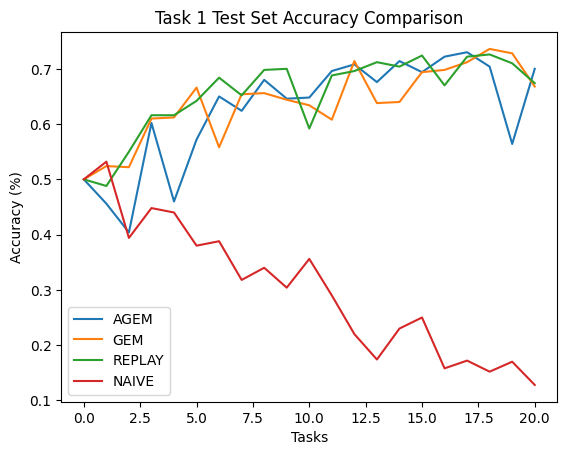

In [8]:

max_runs = 1
test_accuracies_AGEM_all = []
test_accuracies_GEM_all = []
test_accuracies_REPLAY_all = []
test_accuracies_NAIVE_all = []

for i in range(max_runs):
    print(f"Run {i+1}")
    random.shuffle(SHUFFLEDCLASSES)

    model, test_accuracies_AGEM = run_cifar('AGEM', Args())
    print(test_accuracies_AGEM)
    test_accuracies_AGEM_all.append(test_accuracies_AGEM)

    model, test_accuracies_GEM = run_cifar('GEM', Args())
    print(test_accuracies_GEM)
    test_accuracies_GEM_all.append(test_accuracies_GEM)
    
    model, test_accuracies_REPLAY = run_cifar('REPLAY', Args())
    print(test_accuracies_REPLAY)
    test_accuracies_REPLAY_all.append(test_accuracies_REPLAY)
    
    model, test_accuracies_NAIVE = run_cifar('NAIVE', Args())
    print(test_accuracies_NAIVE)
    test_accuracies_NAIVE_all.append(test_accuracies_NAIVE)
    
average_AGEM_accuracies = np.mean(test_accuracies_AGEM_all, axis=0)
average_GEM_accuracies = np.mean(test_accuracies_GEM_all, axis=0)
average_REPLAY_accuracies = np.mean(test_accuracies_REPLAY_all, axis=0)
average_NAIVE_accuracies = np.mean(test_accuracies_NAIVE_all, axis=0)

task_1_accuracies_AGEM = []
task_1_accuracies_GEM = []
task_1_accuracies_REPLAY = []
task_1_accuracies_NAIVE = []
task_1_accuracies_AGEM.append(0.5)
task_1_accuracies_GEM.append(0.5)
task_1_accuracies_REPLAY.append(0.5)
task_1_accuracies_NAIVE.append(0.5)

for i in range(0, N_TASKS * N_TASKS, N_TASKS):
    task_1_accuracies_GEM.append(average_GEM_accuracies[i])
    task_1_accuracies_AGEM.append(average_AGEM_accuracies[i])
    task_1_accuracies_REPLAY.append(average_REPLAY_accuracies[i])
    task_1_accuracies_NAIVE.append(average_NAIVE_accuracies[i])

plt.plot(task_1_accuracies_AGEM, label='AGEM')
plt.plot(task_1_accuracies_GEM, label='GEM')
plt.plot(task_1_accuracies_REPLAY, label='REPLAY')
plt.plot(task_1_accuracies_NAIVE, label='NAIVE')
plt.title('Task 1 Test Set Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Tasks')
plt.legend()
plt.savefig('task_1_accuracy_comparison.png')
plt.show()

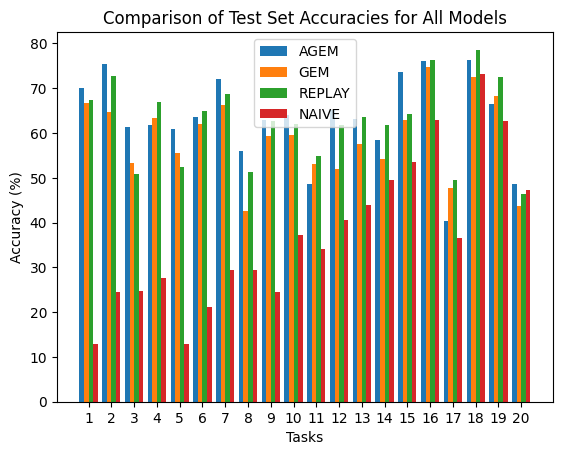

In [9]:
#plot_task_accuracies(average_AGEM_accuracies, N_TASKS)
#plot_task_accuracies(average_GEM_accuracies, N_TASKS)
#plot_task_accuracies(average_REPLAY_accuracies, N_TASKS)
#plot_task_accuracies(average_NAIVE_accuracies, N_TASKS)

#plot_last_task_accuracies(average_AGEM_accuracies, N_TASKS)
plot_comparison_accuracies([average_AGEM_accuracies, average_GEM_accuracies, average_REPLAY_accuracies, average_NAIVE_accuracies], N_TASKS, 4, ['AGEM', 'GEM', 'REPLAY', 'NAIVE'])


In [10]:
import os.path

save_path = '/dcs/large/u2145461/cs407/Machine-Unlearning-x-Continual-Learning/GEM/Results/'

def save_accuracies_to_file(name_of_file, accuracies):
    completeName = os.path.join(save_path, name_of_file+".csv")
    file1 = open(completeName, "w")
    for item in accuracies:
        file1.write("%s\n" % item)
    file1.close()
    
save_accuracies_to_file('task_1_accuracies_AGEM', task_1_accuracies_AGEM)
save_accuracies_to_file('task_1_accuracies_GEM', task_1_accuracies_GEM)
save_accuracies_to_file('task_1_accuracies_REPLAY', task_1_accuracies_REPLAY)
save_accuracies_to_file('task_1_accuracies_NAIVE', task_1_accuracies_NAIVE)

save_accuracies_to_file('average_AGEM_accuracies', average_AGEM_accuracies)
save_accuracies_to_file('average_GEM_accuracies', average_GEM_accuracies)
save_accuracies_to_file('average_REPLAY_accuracies', average_REPLAY_accuracies)
save_accuracies_to_file('average_NAIVE_accuracies', average_NAIVE_accuracies)

save_accuracies_to_file('all_accuracies_AGEM', test_accuracies_AGEM_all)
save_accuracies_to_file('all_accuracies_GEM', test_accuracies_GEM_all)
save_accuracies_to_file('all_accuracies_REPLAY', test_accuracies_REPLAY_all)
save_accuracies_to_file('all_accuracies_NAIVE', test_accuracies_NAIVE_all)
       
